## Credit Card Lead Prediction 

### Importing Required Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import category_encoders as ce

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report

In [3]:
pd.set_option('display.max_columns',500)
pd.set_option('display.width',500)
pd.set_option('display.max_rows', 500)

In [4]:
df_train_data = pd.read_csv('train_s3TEQDk.csv')
df_train_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [5]:
df_test_data = pd.read_csv('test_mSzZ8RL.csv')
df_test_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [6]:
train_data = df_train_data.copy()
test_data = df_test_data.copy()

In [7]:
train_data.shape, test_data.shape

((245725, 11), (105312, 10))

In [8]:
100*len(test_data)/len(train_data)

42.85766609014142

### Details of Null values and Unique values and Data Types

In [9]:
def details(df):
    sum_null_values = df.isnull().sum()
    percent_null_values = 100* (sum_null_values/len(df))
    data_type = df.dtypes
    unique_values = df.nunique()

    table = pd.concat([sum_null_values,percent_null_values,data_type,unique_values], axis=1)
    table_col = table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Missing Values', 2 : 'Data_Type', 3: 'Unique values'})
    return table_col

In [10]:
details(train_data)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
ID,0,0.000000,object,245725
Gender,0,0.000000,object,2
Age,0,0.000000,int64,63
Region_Code,0,0.000000,object,35
Occupation,0,0.000000,object,4
Channel_Code,0,0.000000,object,4
Vintage,0,0.000000,int64,66
Credit_Product,29325,11.934073,object,2
Avg_Account_Balance,0,0.000000,int64,135292
Is_Active,0,0.000000,object,2


In [11]:
details(test_data)

,Missing Values,% of Total Missing Values,Data_Type,Unique values
ID,0,0.000000,object,105312
Gender,0,0.000000,object,2
Age,0,0.000000,int64,62
Region_Code,0,0.000000,object,35
Occupation,0,0.000000,object,4
Channel_Code,0,0.000000,object,4
Vintage,0,0.000000,int64,66
Credit_Product,12522,11.890383,object,2
Avg_Account_Balance,0,0.000000,int64,78315
Is_Active,0,0.000000,object,2


### Differentiating Numerical and Objective columns

In [12]:
cols_obj = train_data.select_dtypes('object').columns
cols_obj

Index(['ID', 'Gender', 'Region_Code', 'Occupation', 'Channel_Code', 'Credit_Product', 'Is_Active'], dtype='object')

In [13]:
cols_num = train_data.select_dtypes('number').columns
cols_num

Index(['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead'], dtype='object')

### Looking at the different categories of categorical columns

In [14]:
train_data.Credit_Product.value_counts(dropna=False)

No     144357
Yes     72043
NaN     29325
Name: Credit_Product, dtype: int64

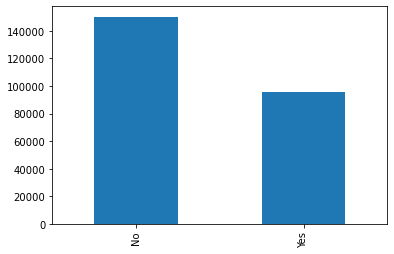

In [15]:
train_data.Is_Active.value_counts().plot.bar()
plt.show()

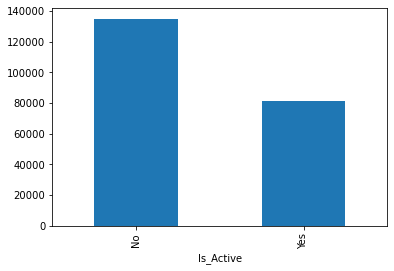

In [16]:
train_data.groupby('Is_Active')['Credit_Product'].count().plot.bar()
plt.show()

### Instead of imputing, null values in the column can be called as different category

In [17]:
train_data['Credit_Product']= train_data['Credit_Product'].replace(np.nan, "Others")
test_data['Credit_Product']= test_data['Credit_Product'].replace(np.nan, "Others")

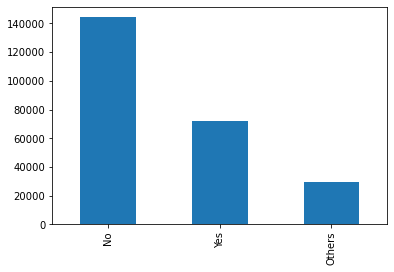

In [18]:
train_data.Credit_Product.value_counts().plot.bar()
plt.show()

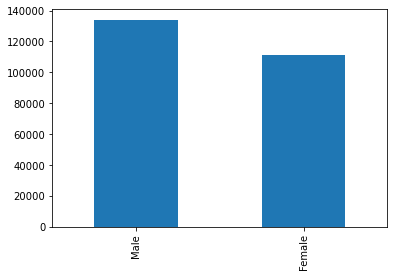

In [19]:
train_data.Gender.value_counts().plot.bar()
plt.show()

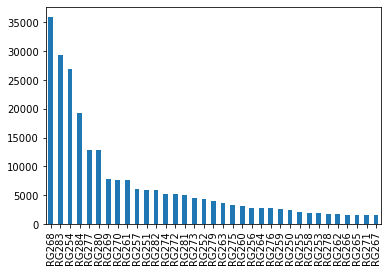

In [20]:
train_data.Region_Code.value_counts().plot.bar()
plt.show()

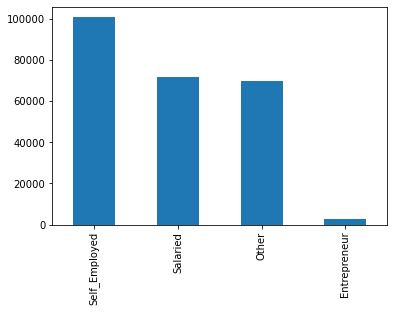

In [21]:
train_data.Occupation.value_counts().plot.bar()
plt.show()

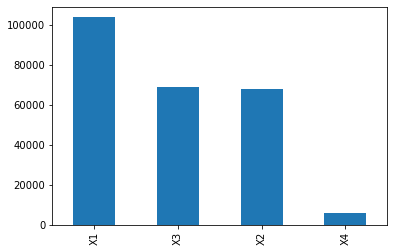

In [22]:
train_data.Channel_Code.value_counts().plot.bar()
plt.show()

In [23]:
train_data.describe(percentiles=(0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99)).apply(lambda s: s.apply('{0:.5f}'.format))

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.00000,245725.00000,245725.00000,245725.00000
mean,43.85631,46.95914,1128403.10102,0.23721
std,14.82867,32.35314,852936.35607,0.42537
min,23.00000,7.00000,20790.00000,0.00000
1%,25.00000,13.00000,233678.00000,0.00000
5%,26.00000,13.00000,352992.80000,0.00000
10%,27.00000,14.00000,432184.00000,0.00000
25%,30.00000,20.00000,604310.00000,0.00000
50%,43.00000,32.00000,894601.00000,0.00000
75%,54.00000,73.00000,1366666.00000,0.00000


### Data Imbalance Check

In [24]:
train_data.Is_Lead.value_counts()

0    187437
1     58288
Name: Is_Lead, dtype: int64

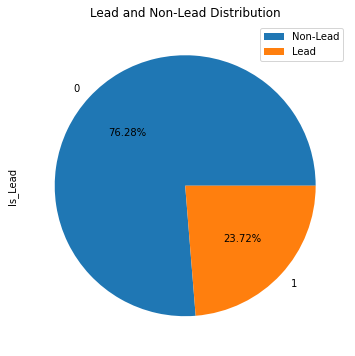

In [25]:
round(100*train_data['Is_Lead'].value_counts(normalize=True),2).plot(kind='pie', figsize=(6, 6), autopct='%1.2f%%')
plt.title("Lead and Non-Lead Distribution")
plt.legend(["Non-Lead", "Lead"])
plt.show()

### Visualizations

In [26]:
# %%time
# row,col,c = 14,3,1
# fig = plt.figure(figsize=(30,80), dpi= 200)

# for i in list(cols_obj):
#     plt.subplot(row,col,c)
#     plt.title(f'{i},subplot:{row}{col}{c}')
#     plt.xlabel(i)
#     train_data[i].value_counts().plot.bar()
#     c = c + 1
# plt.tight_layout()
# plt.show()

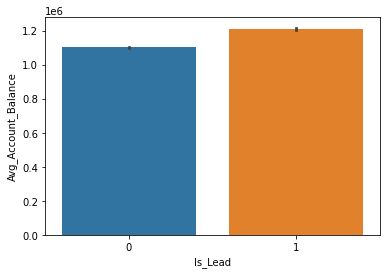

In [27]:
sns.barplot(data=train_data, x='Is_Lead', y='Avg_Account_Balance')
plt.show()

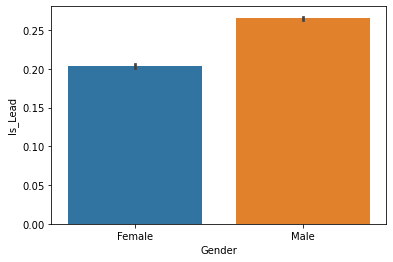

In [28]:
sns.barplot(data=train_data, y='Is_Lead', x='Gender')
plt.show()

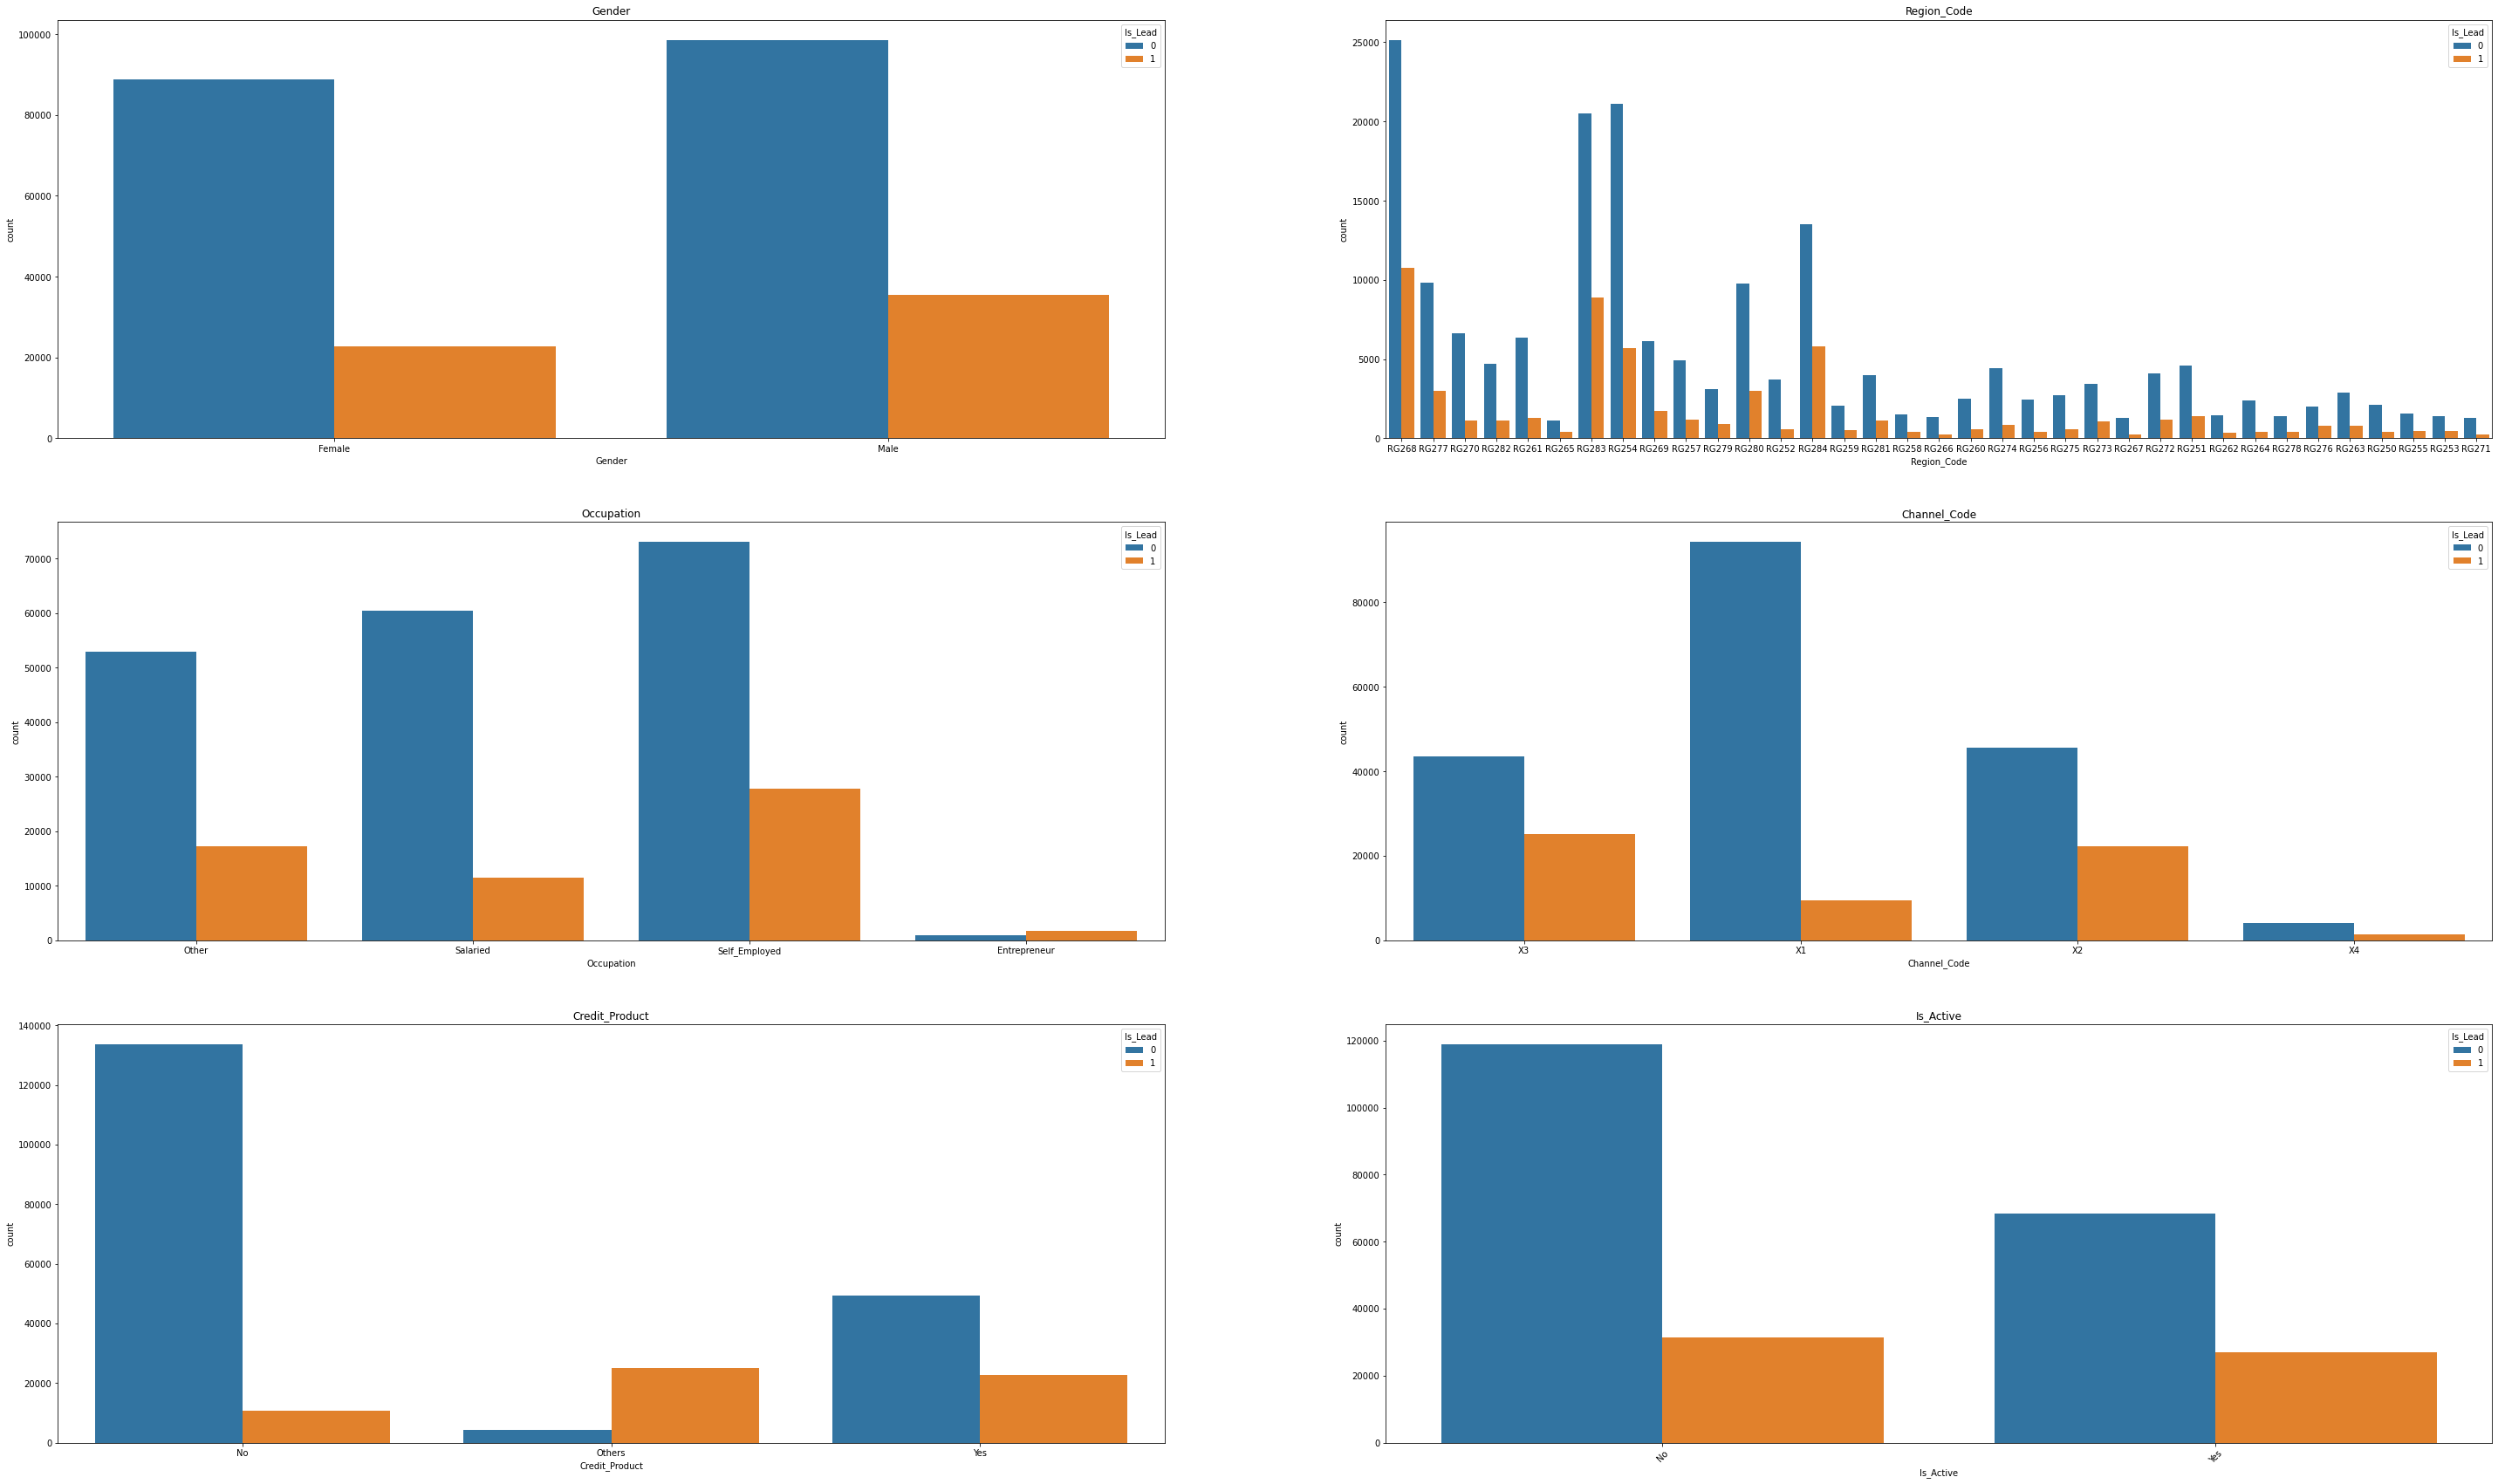

In [29]:
fig, axes = plt.subplots(nrows=3, ncols = 2, figsize=(50,30))

sns.countplot(x="Gender", hue='Is_Lead', data=train_data, ax=axes[0][0])
axes[0][0].set_title('Gender')
plt.xticks(rotation=45)

sns.countplot(x="Region_Code", hue='Is_Lead', data=train_data, ax=axes[0][1])
axes[0][1].set_title('Region_Code')
plt.xticks(rotation=45)

sns.countplot(x="Occupation", hue='Is_Lead', data=train_data, ax=axes[1][0])
axes[1][0].set_title('Occupation')
plt.xticks(rotation=45)

sns.countplot(x="Channel_Code", hue='Is_Lead', data=train_data, ax=axes[1][1])
axes[1][1].set_title('Channel_Code')
plt.xticks(rotation=45)

sns.countplot(x="Credit_Product", hue='Is_Lead', data=train_data, ax=axes[2][0])
axes[2][0].set_title('Credit_Product')
plt.xticks(rotation=45)

sns.countplot(x="Is_Active", hue='Is_Lead', data=train_data, ax=axes[2][1])
axes[2][1].set_title('Is_Active')
plt.xticks(rotation=45)

plt.show()

### Binary Encoding

In [30]:
#This can be kept before new df creation since its common
train_data.Gender = train_data.Gender.map({'Male':1,'Female':0})
train_data.Credit_Product = train_data.Credit_Product.map({'Yes':1,'No':0,'Others':3})
train_data.Is_Active = train_data.Is_Active.map({'Yes':1,'No':0})

In [31]:
test_data.Gender = test_data.Gender.map({'Male':1,'Female':0})
test_data.Credit_Product = test_data.Credit_Product.map({'Yes':1,'No':0,'Others':3})
test_data.Is_Active = test_data.Is_Active.map({'Yes':1,'No':0})

### OneHotEncoding

In [32]:
#OHE
#This can be kept before new df creation since its common
ohe = OneHotEncoder(sparse=False)
ohe_df1 = pd.DataFrame(ohe.fit_transform(train_data[['Region_Code','Occupation','Channel_Code']]),columns=ohe.get_feature_names())
ohe_df2 = pd.DataFrame(ohe.transform(test_data[['Region_Code','Occupation','Channel_Code']]),columns=ohe.get_feature_names())

### Merging the data

In [33]:
train_data = pd.concat([train_data, ohe_df1],1)
test_data = pd.concat([test_data, ohe_df2],1)

In [34]:
train_data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,x0_RG250,x0_RG251,x0_RG252,x0_RG253,x0_RG254,x0_RG255,x0_RG256,x0_RG257,x0_RG258,x0_RG259,x0_RG260,x0_RG261,x0_RG262,x0_RG263,x0_RG264,x0_RG265,x0_RG266,x0_RG267,x0_RG268,x0_RG269,x0_RG270,x0_RG271,x0_RG272,x0_RG273,x0_RG274,x0_RG275,x0_RG276,x0_RG277,x0_RG278,x0_RG279,x0_RG280,x0_RG281,x0_RG282,x0_RG283,x0_RG284,x1_Entrepreneur,x1_Other,x1_Salaried,x1_Self_Employed,x2_X1,x2_X2,x2_X3,x2_X4
0,NNVBBKZB,0,73,RG268,Other,X3,43,0,1045696,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,IDD62UNG,0,30,RG277,Salaried,X1,32,0,581988,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,HD3DSEMC,0,56,RG268,Self_Employed,X3,26,0,1484315,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,BF3NC7KV,1,34,RG270,Salaried,X1,19,0,470454,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,TEASRWXV,0,30,RG282,Salaried,X1,33,0,886787,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [35]:
train_data.drop(['Region_Code','Occupation','Channel_Code'],1,inplace=True)
test_data.drop(['Region_Code','Occupation','Channel_Code'],1,inplace=True)

### Keeping copy of dataset

In [36]:
df_train = train_data.copy()
df_test = test_data.copy()

### Age and Vintage to be made bins for Linear modelling

In [37]:
df_train['Age'] = pd.cut(df_train['Age'], [0,25,50,75,100], labels=['<25','25-50','50-75','>75'])
df_train['Vintage'] = pd.cut(df_train['Vintage'], [0,15,30,45,60,75,90,105,120,200], labels=['<15','15-30','30-45','45-60','60-75','75-90','90-105','105-120','>120'])

df_test['Age'] = pd.cut(df_test['Age'], [0,25,50,75,100], labels=['<25','25-50','50-75','>75'])
df_test['Vintage'] = pd.cut(df_test['Vintage'], [0,15,30,45,60,75,90,105,120,200], labels=['<15','15-30','30-45','45-60','60-75','75-90','90-105','105-120','>120'])

In [38]:
df_train['Age'].value_counts()

25-50    159483
50-75     70212
>75        8817
<25        7213
Name: Age, dtype: int64

In [39]:
df_train['Vintage'].value_counts()

15-30      69237
30-45      40500
<15        38752
90-105     25716
60-75      24736
75-90      16525
45-60      16121
105-120     9565
>120        4573
Name: Vintage, dtype: int64

Text(0.5, 1.0, 'Vintage')

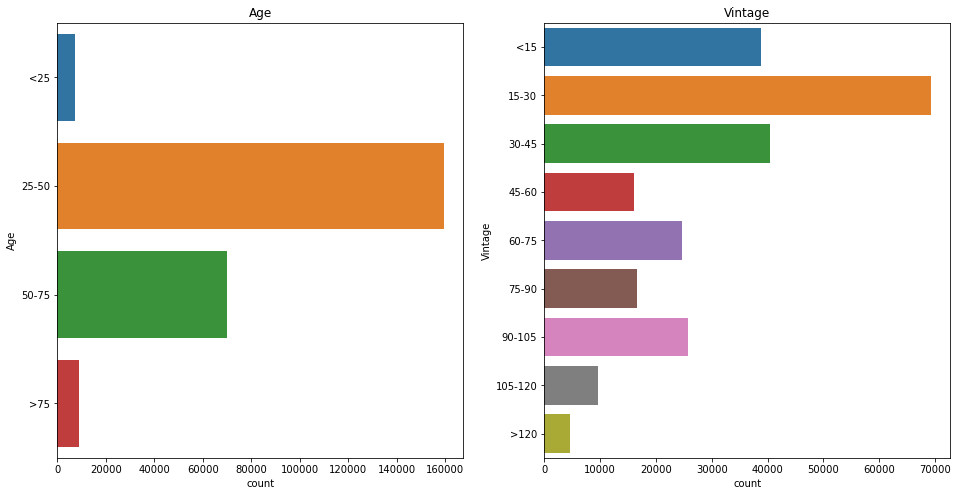

In [40]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.countplot(y="Age", data=df_train)
plt.title('Age')
plt.subplot(1,2,2)
sns.countplot(y="Vintage", data=df_train)
plt.title('Vintage')

In [41]:
ohe_df3 = pd.DataFrame(ohe.fit_transform(df_train[['Age','Vintage']]),columns=ohe.get_feature_names())
ohe_df4 = pd.DataFrame(ohe.transform(df_test[['Age','Vintage']]),columns=ohe.get_feature_names())

In [42]:
df_train = pd.concat([df_train, ohe_df3],1)
df_test = pd.concat([df_test, ohe_df4],1)

In [43]:
df_train.drop(['Age','Vintage'],1,inplace=True)
df_test.drop(['Age','Vintage'],1,inplace=True)

In [44]:
df_train.head()

,ID,Gender,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,x0_RG250,x0_RG251,x0_RG252,x0_RG253,x0_RG254,x0_RG255,x0_RG256,x0_RG257,x0_RG258,x0_RG259,x0_RG260,x0_RG261,x0_RG262,x0_RG263,x0_RG264,x0_RG265,x0_RG266,x0_RG267,x0_RG268,x0_RG269,x0_RG270,x0_RG271,x0_RG272,x0_RG273,x0_RG274,x0_RG275,x0_RG276,x0_RG277,x0_RG278,x0_RG279,x0_RG280,x0_RG281,x0_RG282,x0_RG283,x0_RG284,x1_Entrepreneur,x1_Other,x1_Salaried,x1_Self_Employed,x2_X1,x2_X2,x2_X3,x2_X4,x0_25-50,x0_50-75,x0_<25,x0_>75,x1_105-120,x1_15-30,x1_30-45,x1_45-60,x1_60-75,x1_75-90,x1_90-105,x1_<15,x1_>120
0,NNVBBKZB,0,0,1045696,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,IDD62UNG,0,0,581988,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HD3DSEMC,0,0,1484315,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BF3NC7KV,1,0,470454,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TEASRWXV,0,0,886787,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Splitting data with train and validation set

In [45]:
X = df_train.drop(['ID','Is_Lead'], 1)
y = df_train['Is_Lead']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=23)

In [46]:
df_train.shape

(245725, 62)

In [47]:
cols_obj = df_train.select_dtypes('object').columns
cols_obj

Index(['ID'], dtype='object')

In [48]:
cols_num = df_train.select_dtypes('number').columns
cols_num

Index(['Gender', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active', 'Is_Lead', 'x0_RG250', 'x0_RG251', 'x0_RG252', 'x0_RG253', 'x0_RG254', 'x0_RG255', 'x0_RG256', 'x0_RG257', 'x0_RG258', 'x0_RG259', 'x0_RG260', 'x0_RG261', 'x0_RG262', 'x0_RG263', 'x0_RG264', 'x0_RG265', 'x0_RG266', 'x0_RG267', 'x0_RG268', 'x0_RG269', 'x0_RG270', 'x0_RG271', 'x0_RG272', 'x0_RG273', 'x0_RG274', 'x0_RG275', 'x0_RG276', 'x0_RG277', 'x0_RG278', 'x0_RG279', 'x0_RG280', 'x0_RG281', 'x0_RG282', 'x0_RG283',
       'x0_RG284', 'x1_Entrepreneur', 'x1_Other', 'x1_Salaried', 'x1_Self_Employed', 'x2_X1', 'x2_X2', 'x2_X3', 'x2_X4', 'x0_25-50', 'x0_50-75', 'x0_<25', 'x0_>75', 'x1_105-120', 'x1_15-30', 'x1_30-45', 'x1_45-60', 'x1_60-75', 'x1_75-90', 'x1_90-105', 'x1_<15', 'x1_>120'],
      dtype='object')

### Distplot

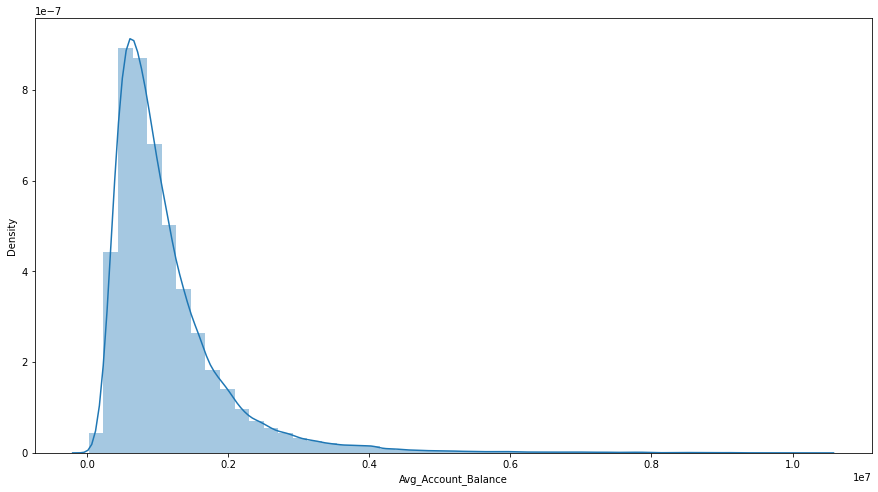

In [49]:
plt.figure(figsize=(15,8))
# for i in enumerate(cols):
#     plt.subplot(1,3,i[0]+1)
sns.distplot(X_train['Avg_Account_Balance'])
plt.show()

### Using Power transformer to bring the data to normal distribution

In [50]:
pt = PowerTransformer(copy=False)
X_train[['Avg_Account_Balance']] = pt.fit_transform(X_train[['Avg_Account_Balance']])
X_val[['Avg_Account_Balance']] = pt.transform(X_val[['Avg_Account_Balance']])
df_test[['Avg_Account_Balance']] = pt.transform(df_test[['Avg_Account_Balance']])

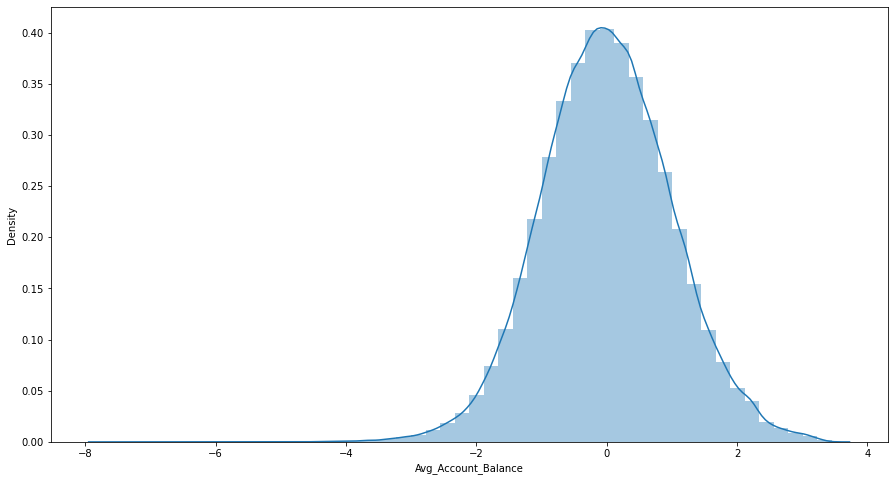

In [51]:
plt.figure(figsize=(15,8))
# for i in enumerate(cols):
#     plt.subplot(1,3,i[0]+1)
sns.distplot(X_train['Avg_Account_Balance'])
plt.show()

In [52]:
X_train.head()

,Gender,Credit_Product,Avg_Account_Balance,Is_Active,x0_RG250,x0_RG251,x0_RG252,x0_RG253,x0_RG254,x0_RG255,x0_RG256,x0_RG257,x0_RG258,x0_RG259,x0_RG260,x0_RG261,x0_RG262,x0_RG263,x0_RG264,x0_RG265,x0_RG266,x0_RG267,x0_RG268,x0_RG269,x0_RG270,x0_RG271,x0_RG272,x0_RG273,x0_RG274,x0_RG275,x0_RG276,x0_RG277,x0_RG278,x0_RG279,x0_RG280,x0_RG281,x0_RG282,x0_RG283,x0_RG284,x1_Entrepreneur,x1_Other,x1_Salaried,x1_Self_Employed,x2_X1,x2_X2,x2_X3,x2_X4,x0_25-50,x0_50-75,x0_<25,x0_>75,x1_105-120,x1_15-30,x1_30-45,x1_45-60,x1_60-75,x1_75-90,x1_90-105,x1_<15,x1_>120
73250,1,0,3.019998,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
72152,1,0,0.332554,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
80416,1,1,-0.766094,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80053,1,0,-1.379284,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
155367,1,3,0.009297,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((172007, 60), (73718, 60), (172007,), (73718,))

### Data Modelling

In [54]:
# Models
model_list = list()
#AUC curve
AUCROC_train = list()
AUCROC_val = list()

### Running Logistic Regression

In [55]:
model_LR = LogisticRegression()

In [56]:
def model_fit(model, X_train, y_train, X_val, y_val, algo=None):
    
    model_LR.fit(X_train, y_train)
    
    y_train_prob = model_LR.predict_proba(X_train)
    y_train_pred = model_LR.predict(X_train)
    y_val_prob = model_LR.predict_proba(X_val)
    y_val_pred = model_LR.predict(X_val)
    
    matrix_train = confusion_matrix(y_train, y_train_pred)
    matrix_val = confusion_matrix(y_val, y_val_pred)
    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_val, y_val_pred)
    auc_train = roc_auc_score(y_train, y_train_prob[:,1])
    auc_val = roc_auc_score(y_val, y_val_prob[:,1])
    
    print('Confusion Matrix for train')
    print('='*60)
    print(matrix_train,"\n")
    print('Confusion Matrix for val')
    print('='*60)
    print(matrix_val,"\n")
    print('Classification Report for train')
    print('='*60)
    print(report_train,"\n")
    print('Classification Report for val')
    print('='*60)
    print(report_val,"\n")
    print('AUC-ROC for train')
    print('='*60)
    print(auc_train,'\n')
    print('AUC-ROC for val')
    print('='*60)
    print(auc_val,'\n')
    print('Roc-Auc-Curve for Train set')
    print('='*60)
    print(plot_roc_curve(model_LR, X_train, y_train),'\n')
    print('Roc-Auc-Curve for Val set')
    print('='*60)
    print(plot_roc_curve(model_LR, X_val, y_val),'\n')
    
    model_list.append(algo)
    AUCROC_train.append(auc_train)
    AUCROC_val.append(auc_val)

In [57]:
def model_fit_evaluation(model, params, X_train, y_train, X_val, y_val, algo=None):
    
    rcv = RandomizedSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=23)
    rcv.fit(X_train, y_train)
    
    rcv_best = rcv.best_estimator_
    print('\n')
    print('best estimator : ', rcv_best)
    print('best parameters: ', rcv.best_params_)
    print('best score: ', rcv.best_score_)
    print('\n')

    y_train_prob = rcv_best.predict_proba(X_train)
    y_train_pred = rcv_best.predict(X_train)
    y_val_prob = rcv_best.predict_proba(X_val)
    y_val_pred = rcv_best.predict(X_val)
    
    matrix_train = confusion_matrix(y_train, y_train_pred)
    matrix_val = confusion_matrix(y_val, y_val_pred)
    report_train = classification_report(y_train, y_train_pred)
    report_val = classification_report(y_val, y_val_pred)
    auc_train = roc_auc_score(y_train, y_train_prob[:,1])
    auc_val = roc_auc_score(y_val, y_val_prob[:,1])
    
    print('Confusion Matrix for train')
    print('='*60)
    print(matrix_train,"\n")
    print('Confusion Matrix for val')
    print('='*60)
    print(matrix_val,"\n")
    print('Classification Report for train')
    print('='*60)
    print(report_train,"\n")
    print('Classification Report for val')
    print('='*60)
    print(report_val,"\n")
    print('AUC-ROC for train')
    print('='*60)
    print(auc_train,'\n')
    print('AUC-ROC for val')
    print('='*60)
    print(auc_val,'\n')
    print('Roc-Auc-Curve for Train set')
    print('='*60)
    print(plot_roc_curve(rcv_best, X_train, y_train),'\n')
    print('Roc-Auc-Curve for Val set')
    print('='*60)
    print(plot_roc_curve(rcv_best, X_val, y_val),'\n')
    
    model_list.append(algo)
    AUCROC_train.append(auc_train)
    AUCROC_val.append(auc_val)

Confusion Matrix for train
[[127495   3780]
 [ 21318  19414]] 

Confusion Matrix for val
[[54544  1618]
 [ 9320  8236]] 

Classification Report for train
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    131275
           1       0.84      0.48      0.61     40732

    accuracy                           0.85    172007
   macro avg       0.85      0.72      0.76    172007
weighted avg       0.85      0.85      0.84    172007
 

Classification Report for val
              precision    recall  f1-score   support

           0       0.85      0.97      0.91     56162
           1       0.84      0.47      0.60     17556

    accuracy                           0.85     73718
   macro avg       0.84      0.72      0.75     73718
weighted avg       0.85      0.85      0.84     73718
 

AUC-ROC for train
0.8624763698250787 

AUC-ROC for val
0.8609660358328215 

Roc-Auc-Curve for Train set

Roc-Auc-Curve for Val set



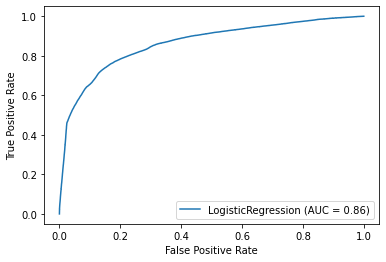

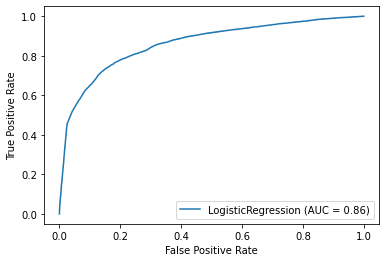

In [58]:
model_fit(model_LR, X_train, y_train, X_val, y_val, algo='Logistic Regression with Hyperparameters')

#### <font color=green> With Logistic Regression without hyperparameters we are getting AUC score of 0.86

In [59]:
params_LR = {'C':np.logspace(-1, 5, 10), 'class_weight':[None,'balanced'], 'penalty':['l1','l2']}

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.0s finished




best estimator :  LogisticRegression(C=0.1, class_weight='balanced')
best parameters:  {'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.1}
best score:  0.862325631597393


Confusion Matrix for train
[[112437  18838]
 [ 10965  29767]] 

Confusion Matrix for val
[[48035  8127]
 [ 4822 12734]] 

Classification Report for train
              precision    recall  f1-score   support

           0       0.91      0.86      0.88    131275
           1       0.61      0.73      0.67     40732

    accuracy                           0.83    172007
   macro avg       0.76      0.79      0.77    172007
weighted avg       0.84      0.83      0.83    172007
 

Classification Report for val
              precision    recall  f1-score   support

           0       0.91      0.86      0.88     56162
           1       0.61      0.73      0.66     17556

    accuracy                           0.82     73718
   macro avg       0.76      0.79      0.77     73718
weighted avg       0.84      0.82    

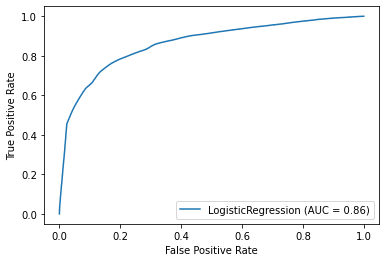

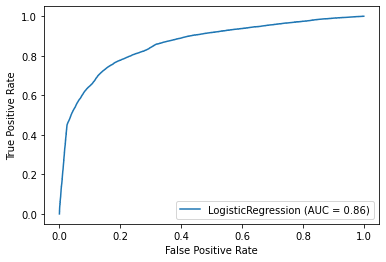

In [60]:
model_fit_evaluation(model_LR, params_LR, X_train, y_train, X_val, y_val, algo='Logistic Regression with Hyperparameter tuning')

#### <font color=green> With Logistic Regression with hyperparameters we are getting AUC score of 0.86

### Decision tree and Random Forest

In [61]:
df_train_tree = train_data.copy()
df_test_tree = test_data.copy()

In [62]:
X = df_train_tree.drop(['ID','Is_Lead'], 1)
y = df_train_tree['Is_Lead']
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, random_state=23)

In [63]:
model_DT = DecisionTreeClassifier(random_state=23)
params_DT = {
    'max_depth': [10, 20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 50, 100, 200],
    'min_samples_split' : [10, 20, 50, 100, 200],
    'criterion': ["gini", "entropy"]
}

Confusion Matrix for train
[[131275      0]
 [ 40732      0]] 

Confusion Matrix for val
[[56162     0]
 [17556     0]] 

Classification Report for train
              precision    recall  f1-score   support

           0       0.76      1.00      0.87    131275
           1       0.00      0.00      0.00     40732

    accuracy                           0.76    172007
   macro avg       0.38      0.50      0.43    172007
weighted avg       0.58      0.76      0.66    172007
 

Classification Report for val
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     56162
           1       0.00      0.00      0.00     17556

    accuracy                           0.76     73718
   macro avg       0.38      0.50      0.43     73718
weighted avg       0.58      0.76      0.66     73718
 

AUC-ROC for train
0.4491303672408334 

AUC-ROC for val
0.44348254079114896 

Roc-Auc-Curve for Train set

Roc-Auc-Curve for Val set



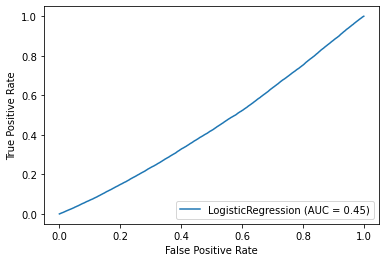

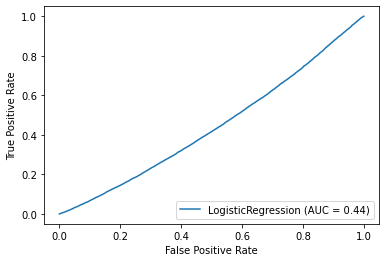

In [64]:
model_fit(model_DT, X_train, y_train, X_val, y_val, algo='Decision Tree without Hyperparameters')

#### <font color=green> With Decision Tree without hyperparameters we are getting AUC score of 0.44

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.5s finished




best estimator :  DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=200,
                       random_state=23)
best parameters:  {'min_samples_split': 200, 'min_samples_leaf': 50, 'max_depth': 10, 'criterion': 'gini'}
best score:  0.8705520179354871


Confusion Matrix for train
[[126595   4680]
 [ 19201  21531]] 

Confusion Matrix for val
[[54086  2076]
 [ 8443  9113]] 

Classification Report for train
              precision    recall  f1-score   support

           0       0.87      0.96      0.91    131275
           1       0.82      0.53      0.64     40732

    accuracy                           0.86    172007
   macro avg       0.84      0.75      0.78    172007
weighted avg       0.86      0.86      0.85    172007
 

Classification Report for val
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     56162
           1       0.81      0.52      0.63     17556

    accuracy                           0.

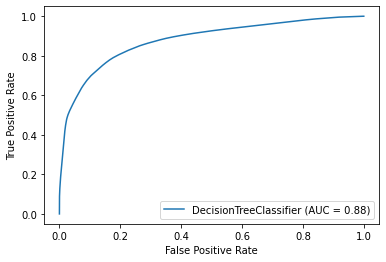

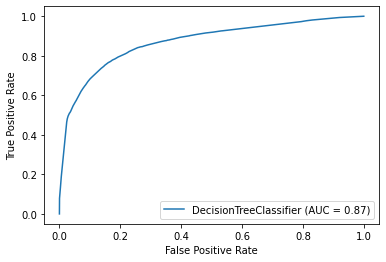

In [65]:
%%time
model_fit_evaluation(model_DT, params_DT, X_train, y_train, X_val, y_val, algo='Decision Tree with Hyperparameter tuning')

#### <font color=green> With Decision Tree with hyperparameters we are getting AUC score of 0.87

In [66]:
model_RF = RandomForestClassifier(oob_score = True, random_state=23)
params_RF = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [10, 20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 50, 100, 200],
    'min_samples_split' : [10, 20, 50, 100, 200],
    'criterion': ["gini", "entropy"]
}

Confusion Matrix for train
[[131275      0]
 [ 40732      0]] 

Confusion Matrix for val
[[56162     0]
 [17556     0]] 

Classification Report for train
              precision    recall  f1-score   support

           0       0.76      1.00      0.87    131275
           1       0.00      0.00      0.00     40732

    accuracy                           0.76    172007
   macro avg       0.38      0.50      0.43    172007
weighted avg       0.58      0.76      0.66    172007
 

Classification Report for val
              precision    recall  f1-score   support

           0       0.76      1.00      0.86     56162
           1       0.00      0.00      0.00     17556

    accuracy                           0.76     73718
   macro avg       0.38      0.50      0.43     73718
weighted avg       0.58      0.76      0.66     73718
 

AUC-ROC for train
0.4491303672408334 

AUC-ROC for val
0.44348254079114896 

Roc-Auc-Curve for Train set

Roc-Auc-Curve for Val set



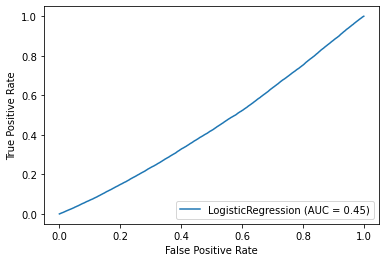

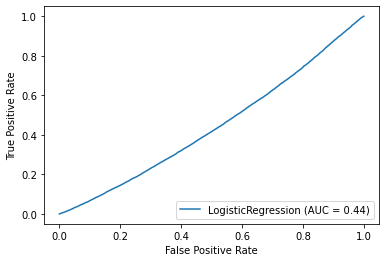

In [67]:
model_fit(model_RF, X_train, y_train, X_val, y_val, algo='Random Forest without Hyperparameters')

#### <font color=green> With Random Forest without hyperparameters we are getting AUC score of 0.44

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished




best estimator :  RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_leaf=50,
                       min_samples_split=50, n_estimators=200, oob_score=True,
                       random_state=23)
best parameters:  {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 50, 'max_depth': 100, 'criterion': 'entropy'}
best score:  0.8709203615833111


Confusion Matrix for train
[[127717   3558]
 [ 20454  20278]] 

Confusion Matrix for val
[[54619  1543]
 [ 8964  8592]] 

Classification Report for train
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    131275
           1       0.85      0.50      0.63     40732

    accuracy                           0.86    172007
   macro avg       0.86      0.74      0.77    172007
weighted avg       0.86      0.86      0.85    172007
 

Classification Report for val
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     

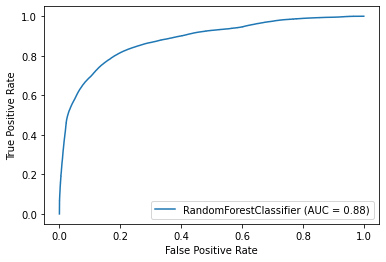

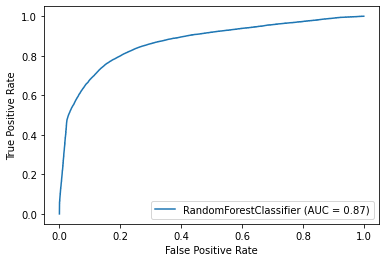

In [68]:
%%time
model_fit_evaluation(model_RF, params_RF, X_train, y_train, X_val, y_val, algo='Random Forest with Hyperparameter tuning')

#### <font color=green> With Random Forest with hyperparameters we are getting AUC score of 0.87

#### <font color=orange> We can see that the AUC score for Random Forest is better with train and validation set showing high AUC scores and hence Random Forest can be used to predict test data.

In [69]:
# model_XGB = XGBClassifier(random_state=23)
# params_XGB = {
#     'n_estimators': [5, 10, 20, 50, 100, 200],
#     'max_depth': [5, 10, 20, 50, 100, 200],
#     'sampling_method': ['uniform','gradient_based'],
#     'subsample': [0.2, 0.4, 0.5, 0.6, 0.8, 1],
#     'learning_rate': [0.01,0.05,0.1,0.2,0.3,0.5,1]
# }

In [70]:
# model_fit(model_XGB, X_train, y_train, X_val, y_val, algo='XGB without Hyperparameters')

In [71]:
#Not running due to lack of system properties
# model_fit_evaluation(model_XGB, params_XGB, X_train, y_train, X_val, y_val, algo='XGB with Hyperparameter tuning')

### Evaluation

In [72]:
eval_df = pd.DataFrame({'model': model_list, 'train_AUC': AUCROC_train, 'val_AUC': AUCROC_val})
eval_df

,model,train_AUC,val_AUC
0,Logistic Regression with Hyperparameters,0.862476,0.860966
1,Logistic Regression with Hyperparameter tuning,0.862840,0.861239
2,Decision Tree without Hyperparameters,0.449130,0.443483
3,Decision Tree with Hyperparameter tuning,0.878075,0.870072
4,Random Forest without Hyperparameters,0.449130,0.443483
5,Random Forest with Hyperparameter tuning,0.881397,0.870125


### Running the entire train dataset to predict on test data set

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.9min finished




best estimator :  RandomForestClassifier(criterion='entropy', max_depth=100, min_samples_leaf=50,
                       min_samples_split=50, n_estimators=200, oob_score=True,
                       random_state=23)
best parameters:  {'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 50, 'max_depth': 100, 'criterion': 'entropy'}
best score:  0.8709739363538194


Confusion Matrix for train
[[181980   5457]
 [ 28760  29528]] 

Classification Report for train
              precision    recall  f1-score   support

           0       0.86      0.97      0.91    187437
           1       0.84      0.51      0.63     58288

    accuracy                           0.86    245725
   macro avg       0.85      0.74      0.77    245725
weighted avg       0.86      0.86      0.85    245725
 

AUC-ROC for train
0.8818793644905333 

Roc-Auc-Curve for Train set

Wall time: 7min 36s


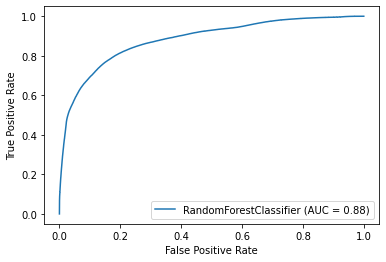

In [73]:
%%time
rcv = RandomizedSearchCV(model_RF, params_RF, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=23)
rcv.fit(X, y)

rcv_best = rcv.best_estimator_
print('\n')
print('best estimator : ', rcv_best)
print('best parameters: ', rcv.best_params_)
print('best score: ', rcv.best_score_)
print('\n')

y_train_prob = rcv_best.predict_proba(X)
y_train_pred = rcv_best.predict(X)

matrix_train = confusion_matrix(y, y_train_pred)
report_train = classification_report(y, y_train_pred)
auc_train = roc_auc_score(y, y_train_prob[:,1])

print('Confusion Matrix for train')
print('='*60)
print(matrix_train,"\n")
print('Classification Report for train')
print('='*60)
print(report_train,"\n")
print('AUC-ROC for train')
print('='*60)
print(auc_train,'\n')
print('Roc-Auc-Curve for Train set')
print('='*60)
print(plot_roc_curve(rcv_best, X, y),'\n')

#### <font color=orange> With Random Forest with hyperparameters we are getting AUC score of 0.86 for entire training dataset.

### Feature importance

In [74]:
rcv_best.feature_importances_
final_df = pd.DataFrame({'Varname': X.columns, 'feature_imp':rcv_best.feature_importances_})
final_df.sort_values(by='feature_imp', ascending=False)

,Varname,feature_imp
3,Credit_Product,0.557393
1,Age,0.121827
2,Vintage,0.098139
45,x2_X1,0.074117
43,x1_Salaried,0.038100
47,x2_X3,0.020824
4,Avg_Account_Balance,0.017149
46,x2_X2,0.016324
5,Is_Active,0.011534
42,x1_Other,0.010373


#### <font color=green> We can see that top 5 variables which are important are: Credit_Product, Age, Vintage, Channel code X1 and Salaried Employee.

### Predicting on Test dataset

In [75]:
#Final prediction
predictions = rcv_best.predict(df_test_tree.drop('ID', axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
submission = pd.DataFrame({ 'ID' : df_test_tree['ID'], 'Is_Lead': predictions })
submission.shape

(105312, 2)

In [86]:
submission.to_csv(r'C:\Users\getch\Documents\Hackathons\AnalyticsVidya\submission.csv', index = False)

In [76]:
submission.head(10)

,ID,Is_Lead
0,VBENBARO,0
1,CCMEWNKY,1
2,VK3KGA9M,0
3,TT8RPZVC,0
4,SHQZEYTZ,0
5,MZZAQMPT,0
6,Y88TW36I,0
7,3UGOAQNU,0
8,VVUKMUJT,1
9,9R363ZXS,0


In [77]:
test_data.head()

,ID,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,x0_RG250,x0_RG251,x0_RG252,x0_RG253,x0_RG254,x0_RG255,x0_RG256,x0_RG257,x0_RG258,x0_RG259,x0_RG260,x0_RG261,x0_RG262,x0_RG263,x0_RG264,x0_RG265,x0_RG266,x0_RG267,x0_RG268,x0_RG269,x0_RG270,x0_RG271,x0_RG272,x0_RG273,x0_RG274,x0_RG275,x0_RG276,x0_RG277,x0_RG278,x0_RG279,x0_RG280,x0_RG281,x0_RG282,x0_RG283,x0_RG284,x1_Entrepreneur,x1_Other,x1_Salaried,x1_Self_Employed,x2_X1,x2_X2,x2_X3,x2_X4
0,VBENBARO,1,29,25,1,742366,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,CCMEWNKY,1,43,49,3,925537,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,VK3KGA9M,1,31,14,0,215949,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,TT8RPZVC,1,29,33,0,868070,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,SHQZEYTZ,0,29,19,0,657087,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


### Merging test data with submission predictions

In [78]:
test_final = pd.merge(left=test_data, right=submission, left_on='ID', right_on='ID')
test_final.head()

,ID,Gender,Age,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,x0_RG250,x0_RG251,x0_RG252,x0_RG253,x0_RG254,x0_RG255,x0_RG256,x0_RG257,x0_RG258,x0_RG259,x0_RG260,x0_RG261,x0_RG262,x0_RG263,x0_RG264,x0_RG265,x0_RG266,x0_RG267,x0_RG268,x0_RG269,x0_RG270,x0_RG271,x0_RG272,x0_RG273,x0_RG274,x0_RG275,x0_RG276,x0_RG277,x0_RG278,x0_RG279,x0_RG280,x0_RG281,x0_RG282,x0_RG283,x0_RG284,x1_Entrepreneur,x1_Other,x1_Salaried,x1_Self_Employed,x2_X1,x2_X2,x2_X3,x2_X4,Is_Lead
0,VBENBARO,1,29,25,1,742366,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,CCMEWNKY,1,43,49,3,925537,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,VK3KGA9M,1,31,14,0,215949,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,TT8RPZVC,1,29,33,0,868070,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,SHQZEYTZ,0,29,19,0,657087,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0


### Merging original test data with submission predictions

In [79]:
test_final_original = pd.merge(left=df_test_data, right=submission, left_on='ID', right_on='ID')
test_final_original.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No,0
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No,1
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No,0
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No,0
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No,0


### Binning age and vintage

In [80]:
test_final['Age_binned'] = pd.cut(test_final['Age'], [0,25,50,75,100], labels=['<25','25-50','50-75','>75'])
test_final['Vintage_binned'] = pd.cut(test_final['Vintage'], [0,15,30,45,60,75,90,105,120,200], labels=['<15','15-30','30-45','45-60','60-75','75-90','90-105','105-120','>120'])
test_final.drop(['Age','Vintage'],1,inplace=True)
test_final.head()

,ID,Gender,Credit_Product,Avg_Account_Balance,Is_Active,x0_RG250,x0_RG251,x0_RG252,x0_RG253,x0_RG254,x0_RG255,x0_RG256,x0_RG257,x0_RG258,x0_RG259,x0_RG260,x0_RG261,x0_RG262,x0_RG263,x0_RG264,x0_RG265,x0_RG266,x0_RG267,x0_RG268,x0_RG269,x0_RG270,x0_RG271,x0_RG272,x0_RG273,x0_RG274,x0_RG275,x0_RG276,x0_RG277,x0_RG278,x0_RG279,x0_RG280,x0_RG281,x0_RG282,x0_RG283,x0_RG284,x1_Entrepreneur,x1_Other,x1_Salaried,x1_Self_Employed,x2_X1,x2_X2,x2_X3,x2_X4,Is_Lead,Age_binned,Vintage_binned
0,VBENBARO,1,1,742366,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,25-50,15-30
1,CCMEWNKY,1,3,925537,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,25-50,45-60
2,VK3KGA9M,1,0,215949,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,25-50,<15
3,TT8RPZVC,1,0,868070,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,25-50,30-45
4,SHQZEYTZ,0,0,657087,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0,25-50,15-30


### Plotting Age and Vintage

Text(0.5, 1.0, 'Vintage')

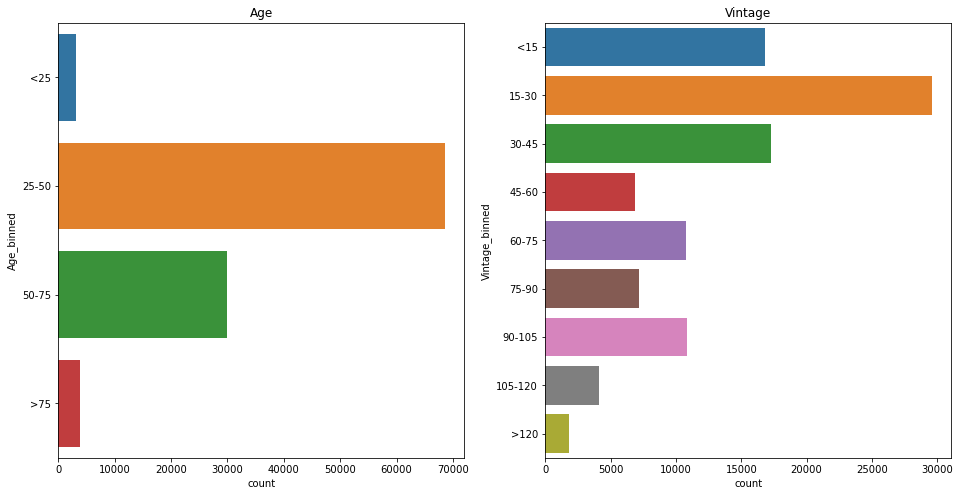

In [81]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
sns.countplot(y="Age_binned", data=test_final)
plt.title('Age')
plt.subplot(1,2,2)
sns.countplot(y="Vintage_binned", data=test_final)
plt.title('Vintage')

### Plotting variables

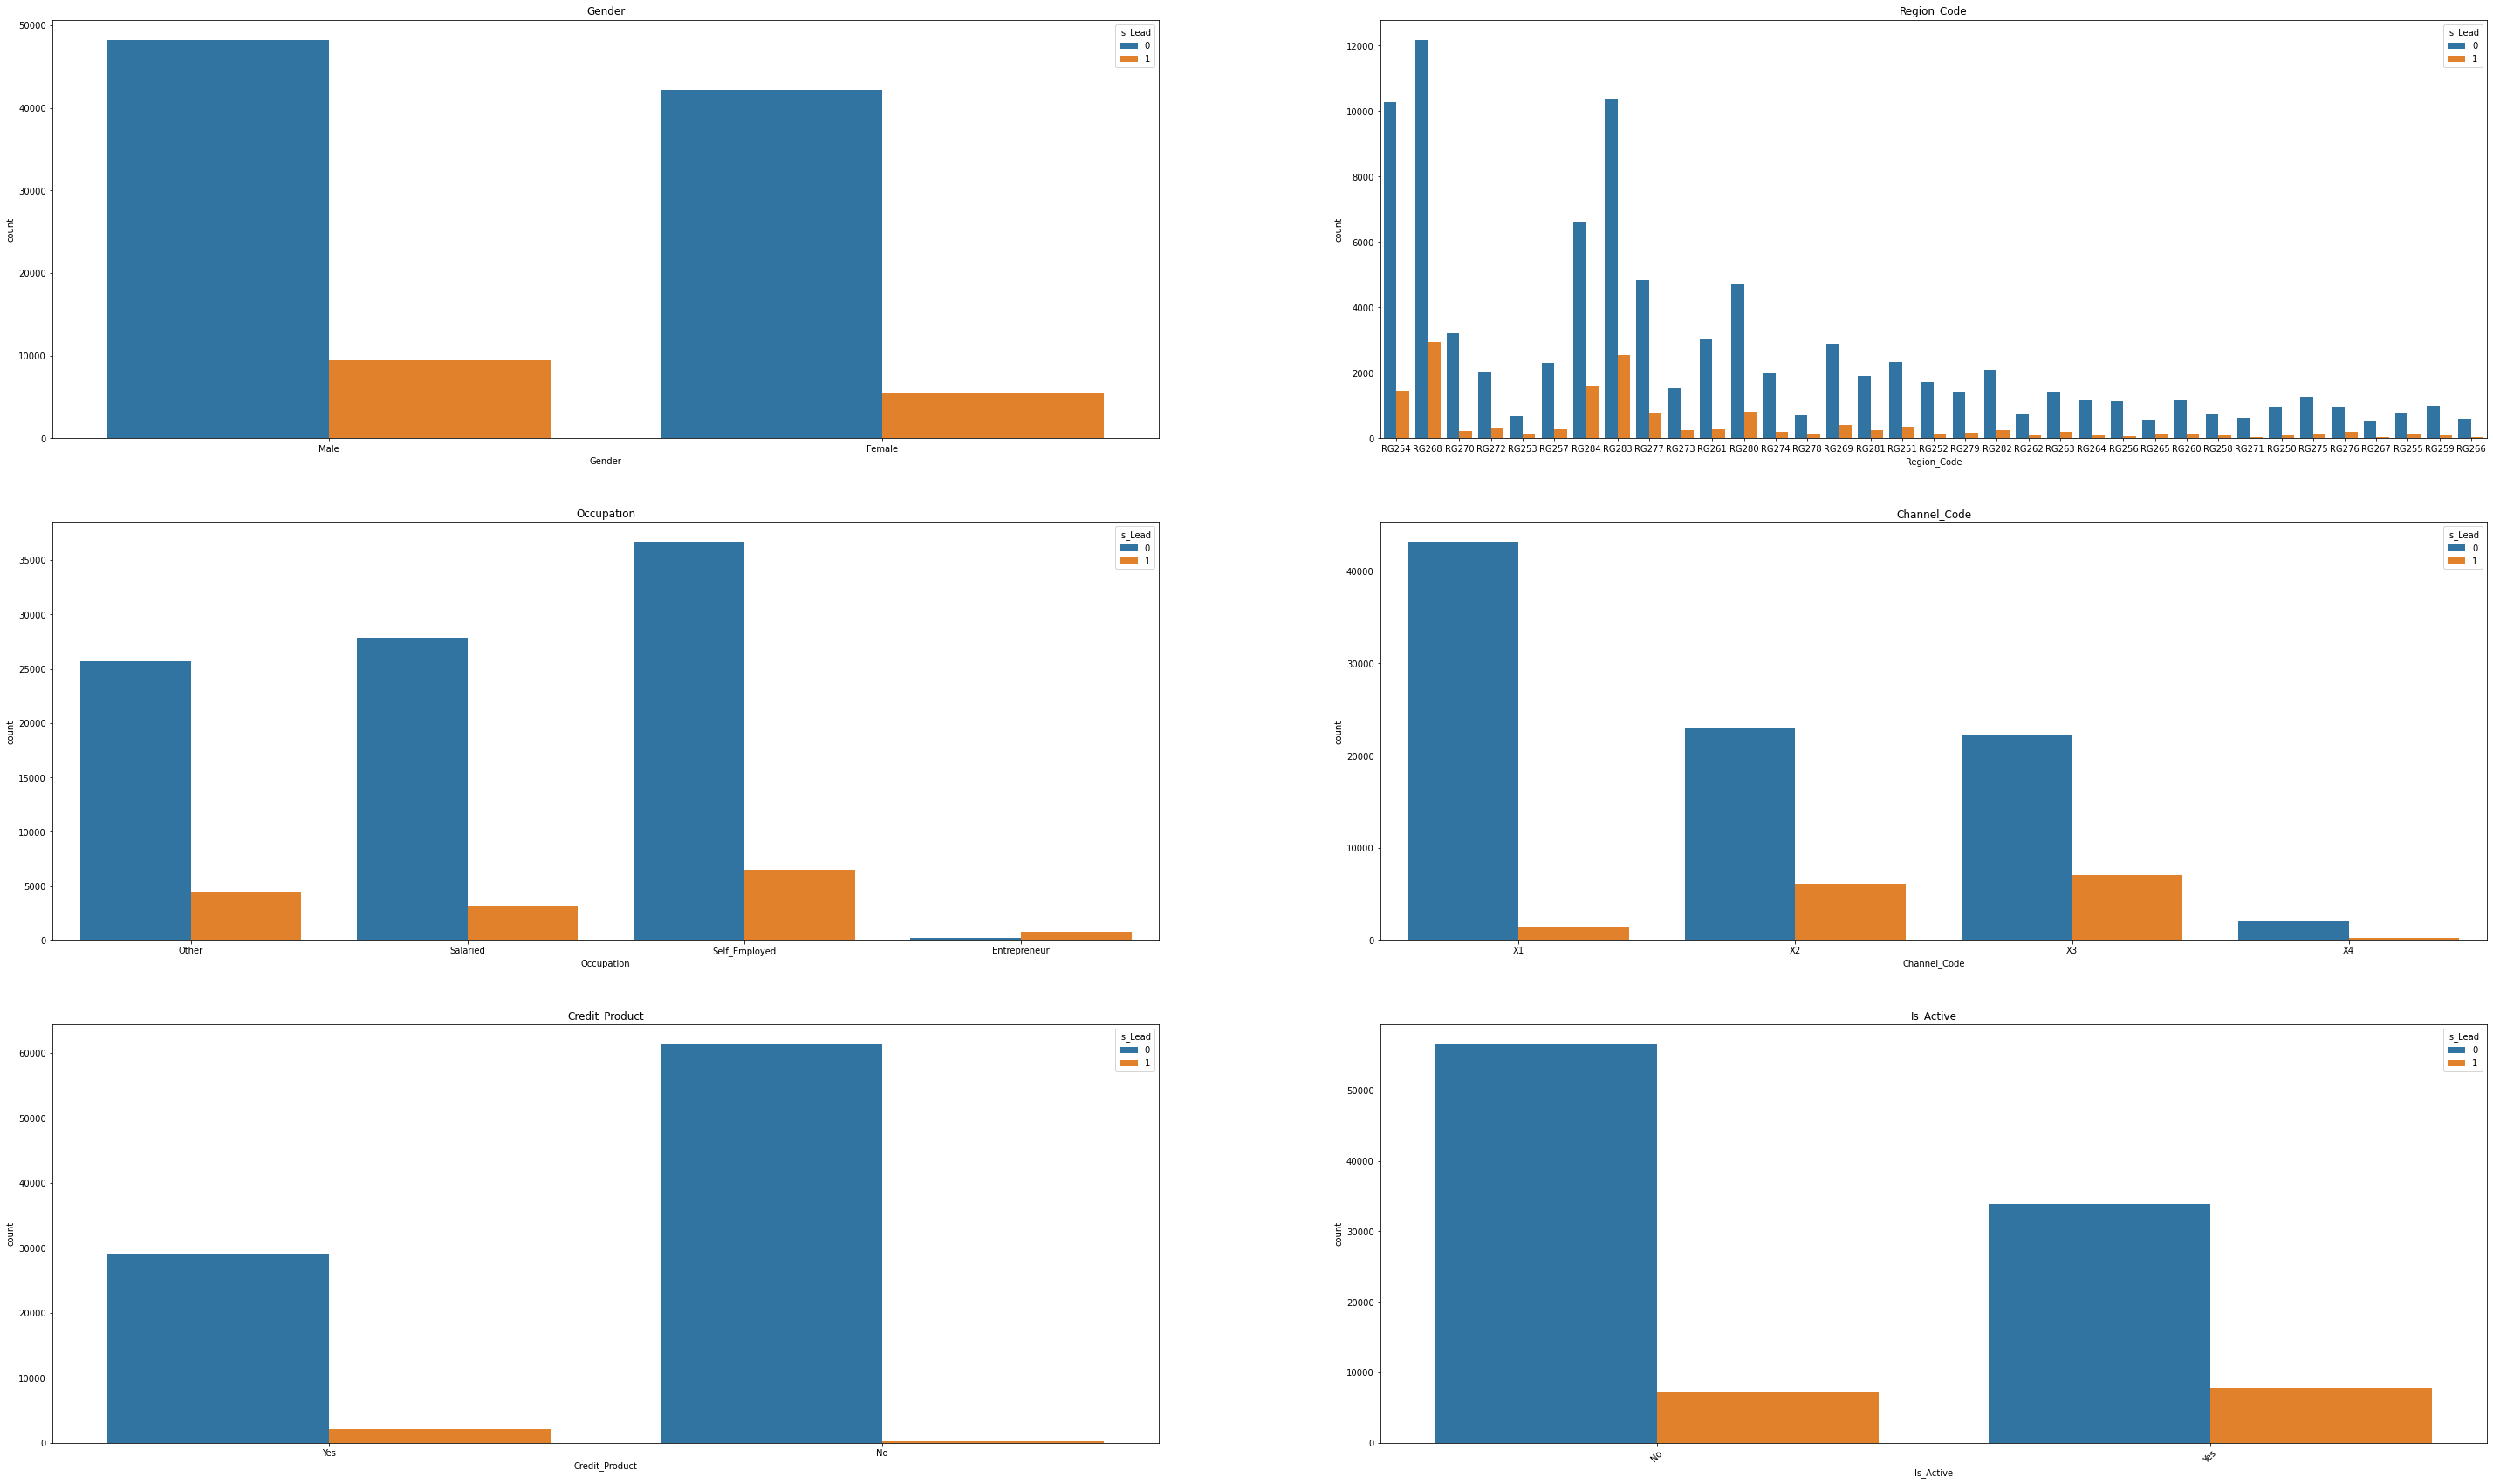

In [82]:
fig, axes = plt.subplots(nrows=3, ncols = 2, figsize=(50,30))

sns.countplot(x="Gender", hue='Is_Lead', data=test_final_original, ax=axes[0][0])
axes[0][0].set_title('Gender')
plt.xticks(rotation=45)

sns.countplot(x="Region_Code", hue='Is_Lead', data=test_final_original, ax=axes[0][1])
axes[0][1].set_title('Region_Code')
plt.xticks(rotation=45)

sns.countplot(x="Occupation", hue='Is_Lead', data=test_final_original, ax=axes[1][0])
axes[1][0].set_title('Occupation')
plt.xticks(rotation=45)

sns.countplot(x="Channel_Code", hue='Is_Lead', data=test_final_original, ax=axes[1][1])
axes[1][1].set_title('Channel_Code')
plt.xticks(rotation=45)

sns.countplot(x="Credit_Product", hue='Is_Lead', data=test_final_original, ax=axes[2][0])
axes[2][0].set_title('Credit_Product')
plt.xticks(rotation=45)

sns.countplot(x="Is_Active", hue='Is_Lead', data=test_final_original, ax=axes[2][1])
axes[2][1].set_title('Is_Active')
plt.xticks(rotation=45)

plt.show()

#### <font color=green> Here we can see that most of the male and female genders will be open to buy credit cards. Some regions are more open than others for getting credit cards. Self employed and salaried people are more approachable compared to Entrepreneurs. Channel code X1 is more approachable compared to other 3 channels. Customers with not many credit products are approachable. Customers who are not very active in last 3 months can be approached.

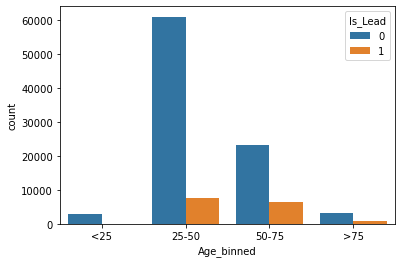

In [83]:
sns.countplot(x="Age_binned", hue='Is_Lead', data=test_final)
plt.show()

#### <font color=green> Here we can see that customers who belong to age group of 25-50 can be approached for selling credit cards.

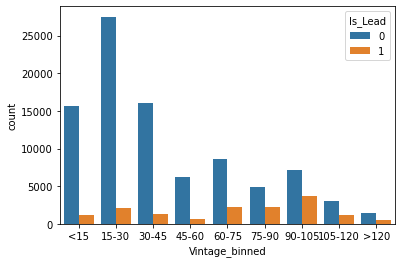

In [84]:
sns.countplot(x="Vintage_binned", hue='Is_Lead', data=test_final)
plt.show()

#### <font color=green> Here we can see that customers belonging to 15-30 month vintage can be approached for credit cards.

### Analysis and Impact

<font color=orange> **Bussiness Impact**: <br>
<font color=blue> Here we can see that: <br>
<font color=blue> - Most of the male and female genders will be open to buy credit cards. <br> 
<font color=blue> - Some regions are more open than others for getting credit cards. <br> 
<font color=blue> - Self employed and salaried people are more approachable compared to Entrepreneurs. <br> 
<font color=blue> - Channel code X1 is more approachable compared to other 3 channels. Customers with not many credit products are approachable. <br> 
<font color=blue> - Customers who are not very active in last 3 months can be approached. <br>
<font color=blue> - I got the AUC value of 0.88 which depicts that the model predicts correctly about customers who can be approached. <br>